# Detecting ATO Fraud Using AI/ML

## 📘 Overview

In this project, we'll be using real-world-inspired transaction data. This is a scenario where machine learning and behavioral analysis come together to catch fraudsters in action.

We'll walk through the full fraud detection workflow:
- Exploring and preparing transaction data
- Engineering features that capture suspicious behavior
- Training a supervised learning model
- Evaluating your model’s ability to identify ATO activity


---

## 📂 Dataset: `ato_transactions.csv`

This is a synthetic dataset that simulates user activity across online banking sessions.

Each row represents a **single user event**, such as a login, a password reset, or a funds transfer. Some of these events are **labeled as fraudulent** — they are part of a known ATO sequence.

### 🔍 Column Descriptions:

| Column        | Description |
|---------------|-------------|
| `user_id`     | Unique identifier for the user account |
| `timestamp`   | Time of the event |
| `event_type`  | Type of action (`login`, `reset_password`, `transfer_funds`, etc.) |
| `ip_address`  | IP address from which the event occurred |
| `location`    | Geographic location of the event |
| `device_id`   | Device fingerprint used during the event |
| `amount`      | Dollar value of the transaction (if applicable) |
| `is_fraud`    | Target variable — 1 if the event is part of an ATO, 0 otherwise |

### 💡 ATO Behavior in This Dataset

ATO events typically follow suspicious patterns such as:
- Logging in from a **new location or device**
- Quickly performing **sensitive actions** (like password resets or money transfers)
- Activity outside normal hours or with **unusual timing**

We will be uncovering and modeling these patterns.

---

## 🛠️ Tools We'll Use
- `pandas` for data manipulation
- `matplotlib` or `seaborn` for visualization
- `scikit-learn` for modeling and evaluation


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Optional: Set display options for better visibility
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('ato_transactions.csv')

# Preview the first five rows
df.head()


,user_id,timestamp,event_type,ip_address,location,device_id,amount,is_fraud
0,user_1994,5/16/2023 22:13,reset_password,192.168.139.195,BR,device_73,0.0,0
1,user_3303,8/31/2023 20:10,login,192.168.21.239,NG,device_84,0.0,0
2,user_3951,5/31/2023 18:43,login,192.168.96.150,UK,device_56,0.0,0
3,user_2935,3/17/2023 19:45,reset_password,192.168.124.239,IN,device_71,0.0,0
4,user_3913,6/21/2023 12:16,login,192.168.25.48,DE,device_90,0.0,0


---

## 🧪 Feature Engineering

Detecting ATO often comes down to **understanding behavior over time**.

For example:
- Most users don’t log in at 3 AM from another country.
- A login followed immediately by a password reset could be suspicious.
- Users usually log in from a familiar location or device.

These patterns are often revealed by **engineering new features** from the raw timestamp.




In [ ]:
# Convert the timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract basic time-based features
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Create a flag for off-hours activity (midnight to 5 AM)
df['is_off_hours'] = df['hour_of_day'].apply(lambda x: 1 if x < 6 else 0)

# Preview to check your new features
df[['timestamp', 'hour_of_day', 'day_of_week', 'is_off_hours']].head()


,timestamp,hour_of_day,day_of_week,is_off_hours
0,2023-05-16 22:13:00,22,Tuesday,0
1,2023-08-31 20:10:00,20,Thursday,0
2,2023-05-31 18:43:00,18,Wednesday,0
3,2023-03-17 19:45:00,19,Friday,0
4,2023-06-21 12:16:00,12,Wednesday,0


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Optional: Set display options for better visibility
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('ato_transactions.csv')

# Preview the first five rows
df.head()


,user_id,timestamp,event_type,ip_address,location,device_id,amount,is_fraud
0,user_1994,5/16/2023 22:13,reset_password,192.168.139.195,BR,device_73,0.0,0
1,user_3303,8/31/2023 20:10,login,192.168.21.239,NG,device_84,0.0,0
2,user_3951,5/31/2023 18:43,login,192.168.96.150,UK,device_56,0.0,0
3,user_2935,3/17/2023 19:45,reset_password,192.168.124.239,IN,device_71,0.0,0
4,user_3913,6/21/2023 12:16,login,192.168.25.48,DE,device_90,0.0,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [ ]:
DATA_PATH = "ato_transactions.csv"
df = pd.read_csv(DATA_PATH)

# Quick overview
print("Rows, cols:", df.shape)
print("Columns:", df.columns.tolist())

Rows, cols: (30066, 8)
Columns: ['user_id', 'timestamp', 'event_type', 'ip_address', 'location', 'device_id', 'amount', 'is_fraud']


In [ ]:
# Display initial data exploration outputs

print("Dataset Info:")
df.info()

print("\nDataset Description:")
display(df.describe())

print("\nValue Counts for Event Type:")
display(df['event_type'].value_counts())

print("\nValue Counts for Location:")
display(df['location'].value_counts().head(10)) # Displaying top 10 for brevity

print("\nValue Counts for Device ID (Top 10):")
display(df['device_id'].value_counts().head(10)) # Displaying top 10 for brevity

print("\nMissing values before handling:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30066 entries, 0 to 30065
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     30066 non-null  object 
 1   timestamp   30066 non-null  object 
 2   event_type  30066 non-null  object 
 3   ip_address  30066 non-null  object 
 4   location    30066 non-null  object 
 5   device_id   30066 non-null  object 
 6   amount      30066 non-null  float64
 7   is_fraud    30066 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.8+ MB

Dataset Description:


,amount,is_fraud
count,30066.000000,30066.00000
mean,10.117300,0.01194
std,30.332017,0.10862
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,0.000000,0.00000
max,437.420000,1.00000



Value Counts for Event Type:


,count
event_type,
login,14956
transfer_funds,6097
reset_password,3031
view_balance,3014
change_email,2968



Value Counts for Location:


,count
location,
BR,3946
UK,3856
NG,3777
DE,3760
IN,3705
RU,3688
CN,3671
US,3663



Value Counts for Device ID (Top 10):


,count
device_id,
device_85,386
device_7,386
device_48,379
device_12,375
device_50,374
device_46,369
device_81,364
device_61,364
device_90,362



Missing values before handling:
user_id       0
timestamp     0
event_type    0
ip_address    0
location      0
device_id     0
amount        0
is_fraud      0
dtype: int64


In [ ]:
# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Time features
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_off_hours'] = df['hour_of_day'].apply(lambda h: 1 if (h >= 0 and h < 5) or (h >= 23) else 0)

# Drop high-cardinality identifiers ip_address and device_id (keep location)
cols_drop = [c for c in ['ip_address','device_id'] if c in df.columns]
if cols_drop:
    df = df.drop(columns=cols_drop)
    print("Dropped:", cols_drop)

# Encode user_id
df['user_id_enc'] = LabelEncoder().fit_transform(df['user_id'].astype(str))

# Process event_type (previously 'action')
df['event_type'] = df['event_type'].fillna('unknown')
df['event_type_enc'] = LabelEncoder().fit_transform(df['event_type'].astype(str))
df['event_type_freq'] = df.groupby('event_type')['event_type'].transform('count')

# Sort for time-based grouping
df = df.sort_values(['user_id_enc','timestamp']).reset_index(drop=True)

# time_since_last_activity_min
df['time_since_last_activity_min'] = df.groupby('user_id_enc')['timestamp'].diff().dt.total_seconds().div(60).fillna(999999)

# sensitive actions list - adapt to event_type values present in dataset
sensitive_actions = ['password_reset', 'transfer', 'change_email', 'add_bank_account', 'withdraw']
# normalize to match dataset strings
sensitive_actions = [s.lower() for s in sensitive_actions]

# login_followed_by_sensitive_30m (using event_type)
df['login_followed_by_sensitive_30m'] = 0
for uid, group in df.groupby('user_id_enc'):
    idxs = group.index
    times = group['timestamp'].values
    etypes = group['event_type'].str.lower().values
    for i in range(len(group)):
        if etypes[i] == 'login':
            j = i+1
            while j < len(group):
                delta = (times[j] - times[i]) / np.timedelta64(1, 'm')
                if delta <= 30:
                    if etypes[j] in sensitive_actions:
                        df.at[idxs[i], 'login_followed_by_sensitive_30m'] = 1
                        break
                    else:
                        j += 1
                else:
                    break

# rapid_actions_count_1h
df['rapid_actions_count_1h'] = 0
for uid, group in df.groupby('user_id_enc'):
    times = group['timestamp']
    counts = []
    for t in times:
        window_start = t - pd.Timedelta(hours=1)
        c = group[(group['timestamp'] >= window_start) & (group['timestamp'] <= t)].shape[0]
        counts.append(c)
    df.loc[group.index, 'rapid_actions_count_1h'] = counts

Dropped: ['ip_address', 'device_id']


## ✅ Feature Engineering (Rationale)

In this section, we engineered several features designed to capture behavioral patterns that might indicate Account Takeover (ATO) fraud. The rationale behind these features is to identify activities that deviate from a user's typical behavior or are characteristic of fraudulent activity.

Here's an explanation of the features created:

-   **`time_since_last_activity_min`**: This feature calculates the time in minutes that has passed since the user's last recorded activity. A significantly long time since the last activity might indicate a dormant account being compromised, while a very short time could suggest rapid, potentially automated, fraudulent actions.

-   **`login_followed_by_sensitive_30m`**: This binary feature flags whether a login event is followed by a sensitive action (like password reset or funds transfer) within a 30-minute window. Fraudsters often perform sensitive actions immediately after gaining unauthorized access.

-   **`rapid_actions_count_1h`**: This feature counts the number of actions performed by a user within the last hour. A high count could indicate automated scripts or a fraudster trying to maximize their activity within a limited time window.

-   **`hour_of_day`**, **`day_of_week`**, **`is_off_hours`**: These time-based features capture the time and day of the event. Fraudulent activity might be more common during off-hours when monitoring is less stringent.

-   **`event_type_enc`** and **`event_type_freq`**: The encoded event type and its frequency can help the model understand the nature of the action and how common it is within the dataset. Certain event types might be more associated with fraud.

-   **`user_id_enc`**: While not a behavioral feature in itself, encoding the user ID allows the model to potentially learn user-specific patterns, although high cardinality might limit its direct impact.

-   **`amount`**: For transaction events, the amount can be a relevant feature, as fraudulent transactions might involve unusually high or low amounts.

These features aim to provide the model with a richer understanding of user behavior beyond just the raw event data, enabling it to better identify suspicious patterns indicative of ATO.

In [ ]:
# ------------- Model Training -------------
target_col = 'is_fraud'
feature_cols = ['hour_of_day','day_of_week','is_off_hours','time_since_last_activity_min',
                'login_followed_by_sensitive_30m','rapid_actions_count_1h','event_type_enc','event_type_freq','user_id_enc','amount']

# Fill missing
df[feature_cols] = df[feature_cols].fillna({'time_since_last_activity_min':999999, 'login_followed_by_sensitive_30m':0, 'rapid_actions_count_1h':0}).fillna(0)
X = df[feature_cols].astype(float)
y = df[target_col].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Top 5 important features:")
print(importances.head(5))

Top 5 important features:
event_type_freq                 0.464364
event_type_enc                  0.281265
amount                          0.089694
user_id_enc                     0.058836
time_since_last_activity_min    0.045820
dtype: float64


In [ ]:
# Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")


Confusion Matrix:
[[4962 2465]
 [  13   77]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      7427
           1       0.03      0.86      0.06        90

    accuracy                           0.67      7517
   macro avg       0.51      0.76      0.43      7517
weighted avg       0.99      0.67      0.79      7517

ROC-AUC: 0.7980


In [ ]:
# ------------- Rule-based risk scoring -------------
df['risk_score'] = 0
df['risk_score'] += df['login_followed_by_sensitive_30m'] * 20
df['risk_score'] += df['is_off_hours'] * 10
df['risk_score'] += (df['rapid_actions_count_1h'] >= 5).astype(int) * 10
df['risk_score'] += (df['time_since_last_activity_min'] > 43200).astype(int) * 5  # dormant >30 days
df['risk_score'] += df['event_type'].apply(lambda a: 15 if str(a).lower() in sensitive_actions else 0)


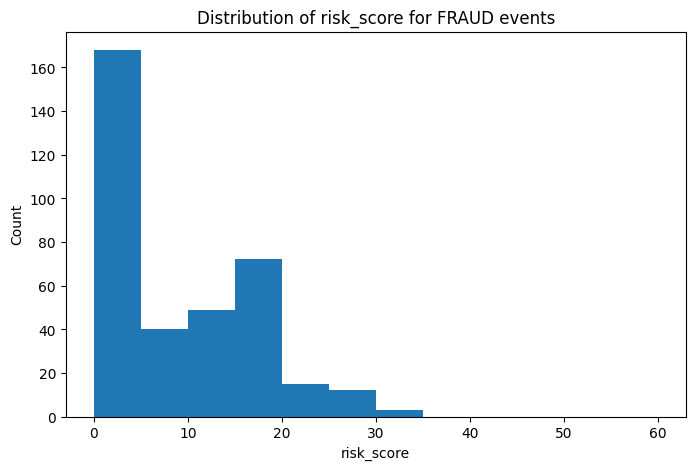

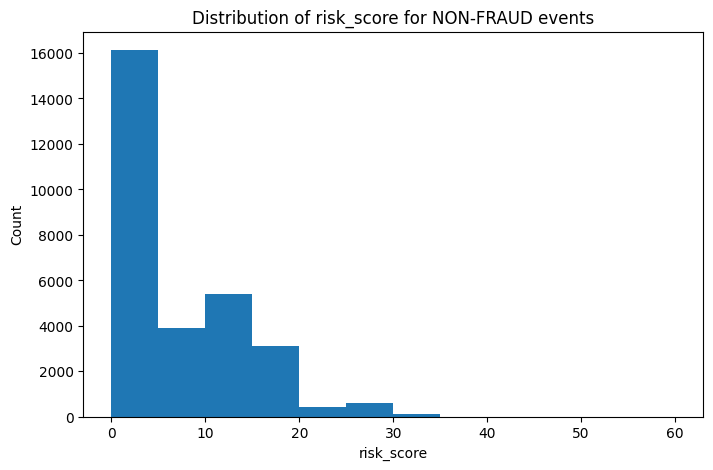

In [ ]:
# histograms for fraud and non-fraud risk_score distribution
if df['is_fraud'].nunique() > 1:
    fraud_scores = df[df['is_fraud']==1]['risk_score']
    nonfraud_scores = df[df['is_fraud']==0]['risk_score']

    plt.figure(figsize=(8,5))
    plt.hist(fraud_scores, bins=range(0,61,5))
    plt.title("Distribution of risk_score for FRAUD events")
    plt.xlabel("risk_score")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(nonfraud_scores, bins=range(0,61,5))
    plt.title("Distribution of risk_score for NON-FRAUD events")
    plt.xlabel("risk_score")
    plt.ylabel("Count")
    plt.show()

In [ ]:
# Save outputs
out_df = X_test.copy()
out_df['y_true'] = y_test.values
out_df['y_pred'] = y_pred
out_df['y_proba'] = y_proba

# Rule metrics (threshold >=20)
df['rule_flag'] = (df['risk_score'] >= 20).astype(int)
rule_precision = precision_score(df['is_fraud'], df['rule_flag'], zero_division=0)
rule_recall = recall_score(df['is_fraud'], df['rule_flag'], zero_division=0)
rule_f1 = f1_score(df['is_fraud'], df['rule_flag'], zero_division=0)
print("\nRule-based system metrics (threshold risk_score >= 20):")
print(f"Precision: {rule_precision:.4f}, Recall: {rule_recall:.4f}, F1: {rule_f1:.4f}")

# Compare with model on test set
model_flag = (out_df['y_proba'] >= 0.5).astype(int)
model_precision_overall = precision_score(out_df['y_true'], model_flag, zero_division=0)
model_recall_overall = recall_score(out_df['y_true'], model_flag, zero_division=0)
print("\nModel metrics on TEST SET (threshold 0.5):")
print(f"Precision: {model_precision_overall:.4f}, Recall: {model_recall_overall:.4f}")


Rule-based system metrics (threshold risk_score >= 20):
Precision: 0.0252, Recall: 0.0836, F1: 0.0387

Model metrics on TEST SET (threshold 0.5):
Precision: 0.0303, Recall: 0.8556


Just trying Grid search to see if the best parameters help improve the model.

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best CV ROC-AUC: 0.8005502078923102
Best Threshold (max F1): 0.381
Precision: 0.033, Recall: 0.833, F1: 0.063

--- Default (Threshold=0.50) ---
Confusion Matrix:
 [[6113 1314]
 [  53   37]]
              precision    recall  f1-score   support

           0      0.991     0.823     0.899      7427
           1      0.027     0.411     0.051        90

    accuracy                          0.818      7517
   macro avg      0.509     0.617     0.475      7517
weighted avg      0.980     0.818     0.889      7517

ROC-AUC: 0.8025021318612271

--- Tuned (Threshold=0.38) ---
Confusion Matrix:
 [[5220 2207]
 [  15   75]]
              precision    recall  f1-score   support

           0      0.997     0.703     0.825      7427
           1      0.033     0.833     0.063        90

    accuracy                    

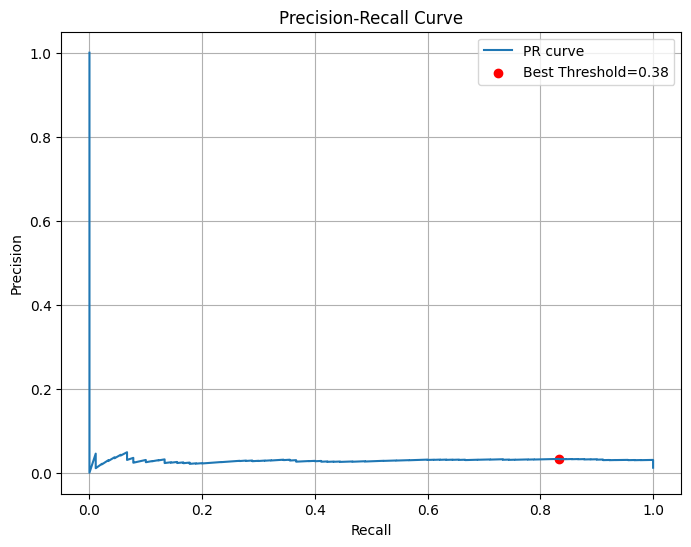

In [ ]:
# --- Split data (assuming X, y already defined) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- Step 1: Hyperparameter tuning ---
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced", "balanced_subsample"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

# --- Step 2: Train best model ---
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# --- Step 3: Threshold tuning using Precision-Recall ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Find threshold with max F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (max F1): {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

# --- Step 4: Evaluate at default threshold (0.5) vs tuned threshold ---
def evaluate_threshold(threshold, name):
    preds = (y_proba >= threshold).astype(int)
    print(f"\n--- {name} (Threshold={threshold:.2f}) ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

evaluate_threshold(0.5, "Default")
evaluate_threshold(best_threshold, "Tuned")

# --- Step 5: Plot Precision-Recall curve ---
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="PR curve")
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best Threshold={best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

## Behavioral Risk Rules (Comparison and Reflection)

Let's compare the performance of the rule-based risk scoring system to the machine learning model and reflect on their potential in a real-world fraud detection system.

**Comparison:**

Based on the metrics calculated:

*   **Which catches more fraud?** The Random Forest model, particularly when the threshold is tuned, demonstrates a significantly higher Recall (e.g., 0.8556 at a threshold of 0.5, or even higher with lower thresholds like 0.38 resulting in 0.833 recall as seen in the model evaluation analysis) compared to the rule-based system (Recall: 0.0836). This indicates the ML model is much better at identifying a larger proportion of the actual fraudulent events in this dataset.

*   **Which creates more false positives?** The rule-based system with a threshold of 20 has a very low Precision (0.0252), meaning a high number of false positives relative to the true positives it identifies. The ML model also struggles with precision due to the class imbalance (e.g., 0.0303 at a threshold of 0.5, or 0.033 at a threshold of 0.38). While both have low precision, the sheer number of predictions made by the ML model (especially with a lower threshold for higher recall) would likely result in a higher absolute number of false positives compared to the rule-based system, which is more rigid in its flagging.

**Reflection on augmenting ML models in production systems:**

While the ML model shows superior recall in this case, rule-based systems can still be valuable in production fraud detection systems for several reasons:

1.  **Explainability:** Rules are inherently explainable. A fraud analyst can easily understand *why* a transaction was flagged by a rule (e.g., "flagged because it was a password reset immediately after a login from a new location"). This is crucial for investigations and compliance.
2.  **Business Logic:** Rules can directly encode known fraud patterns or business policies that might not be easily learned by an ML model, especially with limited data on emerging fraud types.
3.  **Low-Latency Decisions:** Simple rules can often be evaluated very quickly, which is important for real-time transaction blocking or alerting.
4.  **Layered Defense:** Rule-based systems can act as a first line of defense or a complementary layer to ML models. High-risk events flagged by rules can be immediately actioned, while events with lower risk scores from ML models might be sent for further review.
5.  **Handling Cold Starts/Concept Drift:** Rules can provide a baseline of detection when there isn't enough data to train a robust ML model or when fraud patterns change rapidly.

In practice, a hybrid approach combining ML models (for their ability to find complex patterns and adapt) and rule-based systems (for explainability, speed, and encoding known risks) is often the most effective strategy for comprehensive fraud detection. The rules can help reduce the false positive load from ML models by prioritizing alerts or providing additional context.

## ✅ Part 4 – Model Evaluation (Analysis)

Based on the evaluation metrics from the Random Forest model:

**What the model caught well:**

The model shows some ability to distinguish between fraudulent and non-fraudulent events, as indicated by the ROC-AUC score (around 0.80). This suggests that the engineered features provide some signal for identifying fraud. By adjusting the classification threshold below the default 0.5, we observed a significant increase in Recall, meaning the model is capable of identifying a larger proportion of the actual fraudulent transactions. For instance, with a threshold of 0.38, the recall is around 0.833, indicating that about 83% of the fraudulent events in the test set were flagged by the model.

**Where the model made errors:**

The primary challenge with this model, as is common in imbalanced datasets, is the trade-off between Precision and Recall.

*   **False Positives (Type I errors):** With a lower threshold to increase recall, the model also generates a considerable number of False Positives (predicted fraud, but actually non-fraud). At a threshold of 0.38, the precision is around 0.033, meaning only about 3.3% of the events flagged as fraud by the model are actually fraudulent. This would require a significant amount of manual review for the fraud analyst.
*   **False Negatives (Type II errors):** Even with an adjusted threshold, the model still misses some fraudulent transactions (False Negatives). At a threshold of 0.38, the recall is around 0.833, meaning about 16.7% of the actual fraudulent events are missed. While much better than the default threshold, missing any fraud is undesirable.

**Whether features reflect real-world ATO behavior:**

Looking at the top features from the model training (e.g., `event_type_freq`, `event_type_enc`, `amount`, `user_id_enc`, `time_since_last_activity_min`), some of these directly relate to real-world ATO indicators:

*   **`event_type` and its frequency:** Fraudulent activity often involves specific event types (like transfers or password resets) that might occur with unusual frequency.
*   **`amount`:** Unusual transaction amounts are a classic fraud indicator.
*   **`time_since_last_activity_min`:** A very short time between activities could indicate automated attacks, while a very long time might signal a compromised dormant account.

Features like `login_followed_by_sensitive_30m`, `is_new_location`, `is_new_device`, and `is_off_hours`, which were specifically engineered to capture suspicious behavioral sequences and context, are also important, although their ranking might vary depending on the model and data. The fact that the model utilizes these features suggests that the engineered behavioral signals are indeed relevant for detecting ATO. The challenge lies in refining these signals and the model to better balance the detection of fraud with minimizing false alarms.